# Optimal new transmission

This notebook contains different visualization of the online and built capacity.

In [2]:
# Third-party packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Local imports
from utils import get_data
from utils import get_data_sftp
from utils import tech_order, tech_colors

from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline 
%matplotlib qt

plt.style.use("style.txt")
pd.options.display.float_format = '{:,.1f}'.format

#### Notebook constants

In [3]:
hostname="shasta-db1.ream.ucsd.edu"
username="n7gonzalez"
scenario_name = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14',
                 's15','s16','s17','s18','s19','s20','s21','s22','s23','s24','s25']
savefig = False
folder_to_save_results="results_v2/"

figure_names={'s1':1,'s2':2,'s3':3,'s4':4,'s5':5,'s6':6,'s7':7,'s8':8,'s9':9,'s10':10,'s11':11,'s12':12,'s13':13,
              's14':14,'s15':15,'s16':16,'s17':17,'s18':18,'s19':19,'s20':20,'s21':21,'s22':22,'s23':23,'s24':24,
              's25':25}

## Reading scenario inputs and results

In [4]:
# Read file with optimal additions
fname = "BuildTx.csv"
build_Tx = get_data_sftp(hostname, username, scenario_name, fname)
build_Tx = build_Tx[build_Tx['TRANS_BLD_YRS_2']==2050]

In [5]:
# Read input file with existing transmission
fname = "transmission_lines.csv"
existing_Tx = get_data_sftp(hostname, username, scenario_name, fname, fpath="inputs")

In [6]:
build_Tx=build_Tx.replace({"scenario": figure_names})
build_Tx = build_Tx.astype({'scenario':'int'})
existing_Tx=existing_Tx.replace({"scenario": figure_names})
existing_Tx = existing_Tx.astype({'scenario':'int'})

### Data transformation

- Add Tx metadata to output
- Calculate total Tx additions by Tx_line by period
- Sort Tx lines by number
- Transform MW to GW

In [7]:
build_Tx_meta = pd.merge(
    left=build_Tx,
    right=existing_Tx,
    left_on=["TRANS_BLD_YRS_1", "scenario"],
    right_on=["TRANSMISSION_LINE", "scenario"],
)
new_name=build_Tx_meta["TRANSMISSION_LINE"]+build_Tx_meta["trans_lz1"]
build_Tx_meta["Tx_lz"]=build_Tx_meta["TRANSMISSION_LINE"]+": "+build_Tx_meta["trans_lz1"]+" to "+build_Tx_meta["trans_lz2"]


In [8]:
build_Tx_meta

,TRANS_BLD_YRS_1,TRANS_BLD_YRS_2,BuildTx,scenario,TRANSMISSION_LINE,trans_lz1,trans_lz2,trans_length_km,trans_efficiency,existing_trans_cap,trans_dbid,trans_derating_factor,trans_terrain_multiplier,trans_new_build_allowed,Tx_lz
0,1-2,2050,0.0,1,1-2,AZ_APS_E,AZ_APS_N,374.1,1.0,281.0,374,0.9,1.1,1,1-2: AZ_APS_E to AZ_APS_N
1,1-34,2050,0.0,1,1-34,AZ_APS_E,NM_S_TX_EPE,645.3,1.0,657.0,391,0.9,0.9,1,1-34: AZ_APS_E to NM_S_TX_EPE
2,1-4,2050,558.8,1,1-4,AZ_APS_E,AZ_NM_N,255.8,1.0,"3,498.0",355,0.9,1.0,1,1-4: AZ_APS_E to AZ_NM_N
3,1-6,2050,573.9,1,1-6,AZ_APS_E,AZ_PHX,260.7,1.0,"2,928.0",363,0.9,1.3,1,1-6: AZ_APS_E to AZ_PHX
4,1-7,2050,0.0,1,1-7,AZ_APS_E,AZ_SE,307.2,1.0,"4,138.0",384,0.9,1.3,1,1-7: AZ_APS_E to AZ_SE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,8-30,2050,0.0,25,8-30,CAN_ALB,MT_NW,"1,020.0",0.9,0.0,530,0.9,1.5,1,8-30: CAN_ALB to MT_NW
2871,8-9,2050,143.5,25,8-9,CAN_ALB,CAN_BC,"1,024.0",0.9,"1,369.0",523,0.9,1.5,1,8-9: CAN_ALB to CAN_BC
2872,9-43,2050,0.0,25,9-43,CAN_BC,WA_ID_AVA,526.9,1.0,506.0,1619,0.9,1.8,1,9-43: CAN_BC to WA_ID_AVA
2873,9-44,2050,"3,262.5",25,9-44,CAN_BC,WA_N_CEN,441.6,1.0,0.0,1653,0.9,1.7,1,9-44: CAN_BC to WA_N_CEN


In [9]:
build_Tx_MW = build_Tx_meta.pivot_table(
    index="Tx_lz", columns="scenario", values="BuildTx", aggfunc=np.sum
)

In [10]:
build_Tx_MW

scenario,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
Tx_lz,,,,,,,,,,,,,,,,,,,,,
1-2: AZ_APS_E to AZ_APS_N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-34: AZ_APS_E to NM_S_TX_EPE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-4: AZ_APS_E to AZ_NM_N,558.8,538.0,"1,082.3","1,368.8","1,616.0",518.0,594.1,"1,300.8","1,753.2","1,783.7",...,"2,466.1","2,427.9","2,274.9","2,816.6","2,622.2","3,597.3","3,580.9","3,408.1","3,464.3","2,846.9"
1-6: AZ_APS_E to AZ_PHX,573.9,553.3,"1,008.1","1,715.1","1,784.7",555.6,574.6,"1,194.6","1,967.2","1,958.3",...,"2,089.9","2,058.5","1,908.5","2,441.6","2,253.7","3,206.9","3,190.7","3,020.7","3,076.0","2,464.0"
1-7: AZ_APS_E to AZ_SE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8-30: CAN_ALB to MT_NW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8-9: CAN_ALB to CAN_BC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.5,34.9,49.8,122.1,133.8,133.0,133.1,138.7,128.0,143.5
9-43: CAN_BC to WA_ID_AVA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Extract number of Tx lines into two separate columns
build_Tx_MW["index1"] = build_Tx_MW.index.str.extract("(\d+)", expand=False).astype(int)
build_Tx_MW["index2"] = build_Tx_MW.index.str.extract(".-(\d+)", expand=False).astype(int)

# Sort TX lines by no. of tx
build_Tx_MW = build_Tx_MW.sort_values(["index1", "index2"]).loc[
    :, build_Tx.scenario.unique()
]

# Convert units
build_Tx_GW = build_Tx_MW / 1e3  # MW to GW
build_Tx_GW


scenario,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
Tx_lz,,,,,,,,,,,,,,,,,,,,,
1-2: AZ_APS_E to AZ_APS_N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-4: AZ_APS_E to AZ_NM_N,0.6,0.5,1.1,1.4,1.6,0.5,0.6,1.3,1.8,1.8,...,2.5,2.4,2.3,2.8,2.6,3.6,3.6,3.4,3.5,2.8
1-6: AZ_APS_E to AZ_PHX,0.6,0.6,1.0,1.7,1.8,0.6,0.6,1.2,2.0,2.0,...,2.1,2.1,1.9,2.4,2.3,3.2,3.2,3.0,3.1,2.5
1-7: AZ_APS_E to AZ_SE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-34: AZ_APS_E to NM_S_TX_EPE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47-48: WY_NE to WY_NW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47-49: WY_NE to WY_SE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48-49: WY_NW to WY_SE,9.2,9.1,9.2,8.9,9.0,9.3,9.1,9.1,9.0,9.2,...,12.4,12.5,13.4,13.7,13.8,13.5,13.3,13.0,13.8,14.0


## Analysis of results

In [12]:
build_Tx_total_GW = pd.DataFrame(build_Tx_GW.sum(axis=0)).rename(columns={0:'Tx_total_GW'})
build_Tx_total_GW

,Tx_total_GW
scenario,
1,92.0
2,90.6
3,91.1
4,89.6
5,90.4
6,92.9
7,91.0
8,91.4
9,90.4


In [13]:
transmission_scen_map = pd.DataFrame(range(1,6))
transmission_scen_map = transmission_scen_map.rename(columns={0:'1'})
transmission_scen_map['2'] = 0
transmission_scen_map['3'] = 0
transmission_scen_map['4'] = 0
transmission_scen_map['5'] = 0
transmission_scen_map

,1,2,3,4,5
0,1,0,0,0,0
1,2,0,0,0,0
2,3,0,0,0,0
3,4,0,0,0,0
4,5,0,0,0,0


In [14]:
for i in range(1,6):
    transmission_scen_map.loc[i-1,'1'] = build_Tx_total_GW.loc[i,'Tx_total_GW']

for i in range(6,11):
    transmission_scen_map.loc[i-6,'2'] = build_Tx_total_GW.loc[i,'Tx_total_GW']

for i in range(11,16):
    transmission_scen_map.loc[i-11,'3'] = build_Tx_total_GW.loc[i,'Tx_total_GW']

for i in range(16,21):
    transmission_scen_map.loc[i-16,'4'] = build_Tx_total_GW.loc[i,'Tx_total_GW']

for i in range(21,26):
    transmission_scen_map.loc[i-21,'5'] = build_Tx_total_GW.loc[i,'Tx_total_GW']

transmission_scen_map = transmission_scen_map.rename(index={0:1,1:2,2:3,3:4,4:5})
transmission_scen_map.style.background_gradient(cmap="Oranges",axis=None)

,1,2,3,4,5
1,92.022445,92.938112,120.043865,149.297572,161.832568
2,90.630970,91.021420,120.195739,148.772822,161.760751
3,91.127776,91.391570,118.884846,148.077235,158.744690
4,89.564356,90.389990,117.049020,146.018414,157.439854
5,90.420274,90.773626,116.534584,136.613520,149.521828


In [15]:
transmission_scen_map_for_paper = transmission_scen_map.copy()
transmission_scen_map_for_paper = transmission_scen_map_for_paper.rename(columns={'1':'$4,746','2':'$4,458','3':'$3,468','4':'$3,017','5':'$2,728'})
transmission_scen_map_for_paper = transmission_scen_map_for_paper.rename(index={1:'$1,462',2:'$1,333',3:'$760',4:'$618',5:'$400'})
transmission_scen_map_for_paper = transmission_scen_map_for_paper.style.background_gradient(cmap="Oranges",axis=None).set_precision(2)
transmission_scen_map_for_paper

/var/folders/bd/5zkgv6rx32s3b0jx_9373xhc0000gn/T/ipykernel_80439/3706141687.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  transmission_scen_map_for_paper = transmission_scen_map_for_paper.style.background_gradient(cmap="Oranges",axis=None).set_precision(2)


,"$4,746","$4,458","$3,468","$3,017","$2,728"
"$1,462",92.02,92.94,120.04,149.30,161.83
"$1,333",90.63,91.02,120.20,148.77,161.76
$760,91.13,91.39,118.88,148.08,158.74
$618,89.56,90.39,117.05,146.02,157.44
$400,90.42,90.77,116.53,136.61,149.52


In [16]:
built_tx_by_scen_list = []
for i in range(1,len(transmission_scen_map)+1):
    row_list = transmission_scen_map.loc[i, :].values.flatten().tolist()
    built_tx_by_scen_list = built_tx_by_scen_list + row_list
built_tx_by_scen_list

[92.0224451,
 92.93811200000002,
 120.043865,
 149.297572,
 161.83256799999998,
 90.63096999999999,
 91.0214197,
 120.195739,
 148.772822,
 161.76075100000003,
 91.12777600000001,
 91.39157,
 118.88484599999998,
 148.077235,
 158.74469000000002,
 89.564356,
 90.38999000000001,
 117.04901999999998,
 146.018414,
 157.439854,
 90.42027399999999,
 90.773626,
 116.5345841,
 136.61352,
 149.52182799999997]

In [18]:
fig = plt.figure(dpi=150)
ax1 = fig.add_subplot(111, projection='3d')

x3 = [1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5]
y3 = [1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5]
z3 = np.zeros(25)

dx = np.ones(25)
dy = np.ones(25)
dz = built_tx_by_scen_list
cmap = cm.get_cmap('Oranges')
norm = Normalize(vmin=85, vmax=165)
colors = cmap(norm(dz))

sc = cm.ScalarMappable(cmap=cmap,norm=norm)
sc.set_array([])
cbar = plt.colorbar(sc, fraction=0.03, pad = 0.15)
cbar.ax.set_ylabel('Transmission Built Capacity (GW)', rotation=270, fontsize = 8, labelpad=15)
cbar.ax.tick_params(labelsize=8)

ax1.bar3d(x3, y3, z3, dx, dy, dz, color=colors)

ax1.set_xlabel('Floating Offshore Wind\nEnergy Overnight Costs',fontsize=8, labelpad=20)
ax1.set_ylabel('Wave Energy\nOvernight Costs',fontsize=8, labelpad=20)
ax1.set_zlabel('Transmission Built Capacity (GW)',fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=5)

x_labels = [item.get_text() for item in ax1.get_xticklabels()]
x_labels[1] = '$4,746/kW'
x_labels[2] = '$4,458/kW'
x_labels[3] = '$3,468/kW'
x_labels[4] = '$3,017/kW'
x_labels[5] = '$2,728/kW'
ax1.set_xticklabels(x_labels)
plt.setp(ax1.get_xticklabels(), rotation=30)

y_labels = [item.get_text() for item in ax1.get_yticklabels()]
y_labels[3] = '$1,462/kW'
y_labels[4] = '$1,333/kW'
y_labels[5] = '$760/kW'
y_labels[6] = '$618/kW'
y_labels[7] = '$400/kW'
ax1.set_yticklabels(y_labels)
plt.setp(ax1.get_yticklabels(), rotation=-10)

plt.show()

/var/folders/bd/5zkgv6rx32s3b0jx_9373xhc0000gn/T/ipykernel_40547/164912050.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_labels)
/var/folders/bd/5zkgv6rx32s3b0jx_9373xhc0000gn/T/ipykernel_40547/164912050.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(y_labels)


In [15]:
sc= list(build_Tx_total_GW.index)
plot_1=sc[0:5]
plot_2=sc[5:10]
plot_3=sc[10:15]
plot_4=sc[15:20]
plot_5=sc[20:25]
group_1 = build_Tx_total_GW.loc[plot_1,:]
group_2 = build_Tx_total_GW.loc[plot_2,:]
group_3 = build_Tx_total_GW.loc[plot_3,:]
group_4 = build_Tx_total_GW.loc[plot_4,:]
group_5 = build_Tx_total_GW.loc[plot_5,:]

### Distribution of capacity 

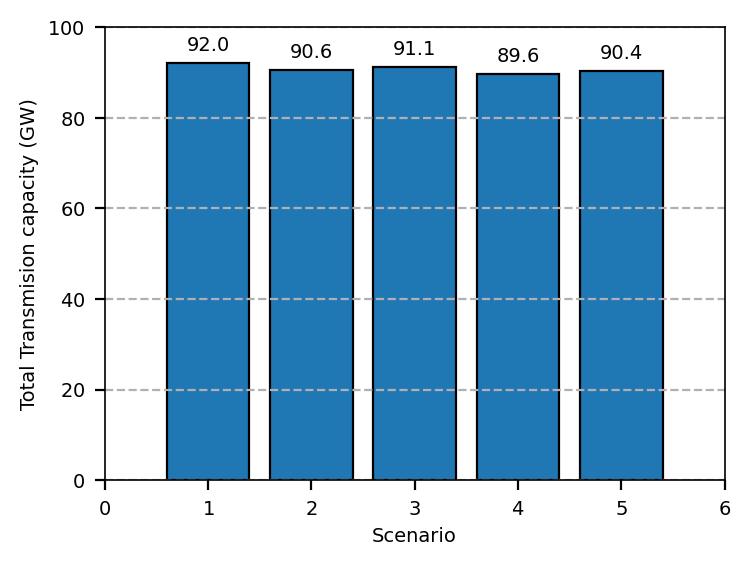

In [16]:
plt.show()

plt.rc('xtick', labelsize=7) 
plt.rc('ytick', labelsize=7) 

fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
fig.subplots_adjust(wspace=.3)

fig.patch.set_facecolor('white')

p1 = ax.bar(group_1.index,height=group_1['Tx_total_GW'])
#ax.set_title('Total Transmission Capacity in WECC Scenarios 190-194',fontsize=7)
ax.set_xlabel("Scenario",fontsize=7)
ax.set_ylabel("Total Transmision capacity (GW)",fontsize=7)
ax.grid(axis='y', linestyle='dashed')

for p in p1:
   height = p.get_height()
   ax.annotate('{:,.1f}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

#fig.suptitle("Total Transmission Capacity in WECC per Scenario",fontsize=7)
ax.patch.set_facecolor('white')
fig.patch.set_facecolor('white')

plt.savefig("Transmission capacity in WECC (Scenarios 1-5).png", transparent=False)

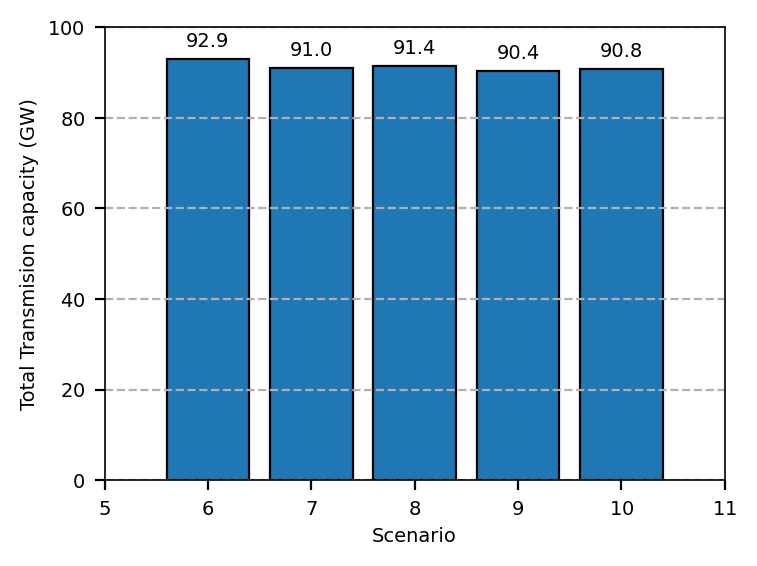

In [25]:
plt.show()

plt.rc('xtick', labelsize=7) 
plt.rc('ytick', labelsize=7) 

fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
fig.subplots_adjust(wspace=.3)

fig.patch.set_facecolor('white')

p2 = ax.bar(group_2.index,height=group_2['Tx_total_GW'])
#ax.set_title('Total Transmission Capacity in WECC Scenarios 190-194',fontsize=7)
ax.set_xlabel("Scenario",fontsize=7)
ax.set_ylabel("Total Transmision capacity (GW)",fontsize=7)
ax.grid(axis='y', linestyle='dashed')

for p in p2:
   height = p.get_height()
   ax.annotate('{:,.1f}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

#fig.suptitle("Total Transmission Capacity in WECC per Scenario",fontsize=7)
#ax.patch.set_facecolor('white')

plt.savefig("Transmission capacity in WECC (Scenarios 6-10).png", transparent=False)

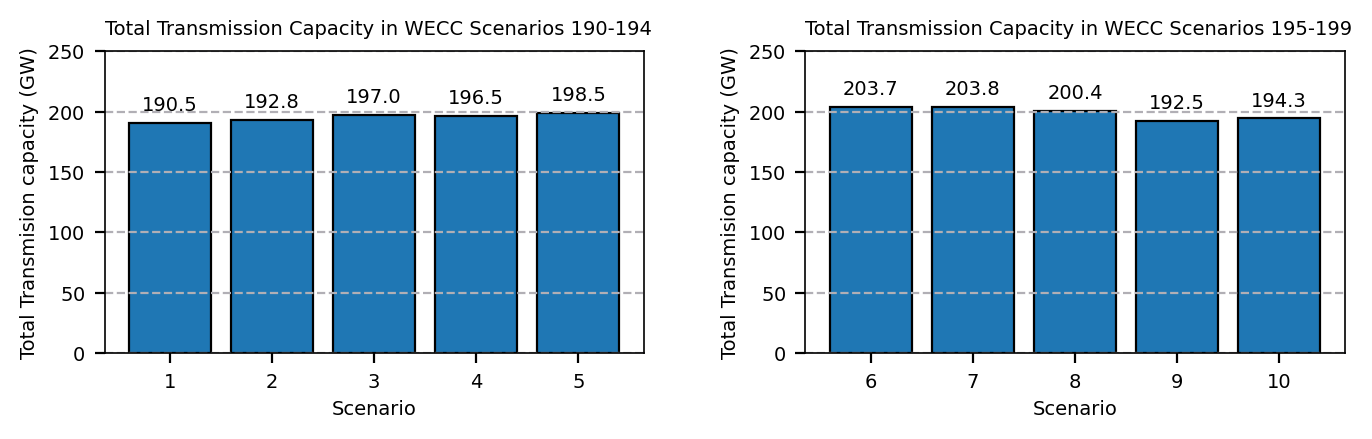

In [68]:
plt.show()

plt.rc('xtick', labelsize=7) 
plt.rc('ytick', labelsize=7) 

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8, 2), dpi=200)
fig.subplots_adjust(wspace=.3)

fig.patch.set_facecolor('white')

p1 = ax1.bar(group_1.index,height=group_1['Tx_total_GW'])
ax1.set_title('Total Transmission Capacity in WECC Scenarios 190-194',fontsize=7)
ax1.set_xlabel("Scenario",fontsize=7)
ax1.set_ylabel("Total Transmision capacity (GW)",fontsize=7)
ax1.grid(axis='y', linestyle='dashed')

for p in p1:
   height = p.get_height()
   ax1.annotate('{:,.1f}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

p2 = ax2.bar(group_2.index,height=group_2['Tx_total_GW'])
ax2.set_title('Total Transmission Capacity in WECC Scenarios 195-199',fontsize=7)
ax2.set_xlabel("Scenario",fontsize=7)
ax2.set_ylabel("Total Transmision capacity (GW)",fontsize=7)
ax2.grid(axis='y', linestyle='dashed')

for p in p2:
   height = p.get_height()
   ax2.annotate('{:,.1f}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

#fig.suptitle("Total Transmission Capacity in WECC per Scenario",fontsize=7)
#ax1.patch.set_facecolor('white')

plt.savefig("Transmission capacity in WECC (subplots).png", transparent=False)

IndexError: list index out of range

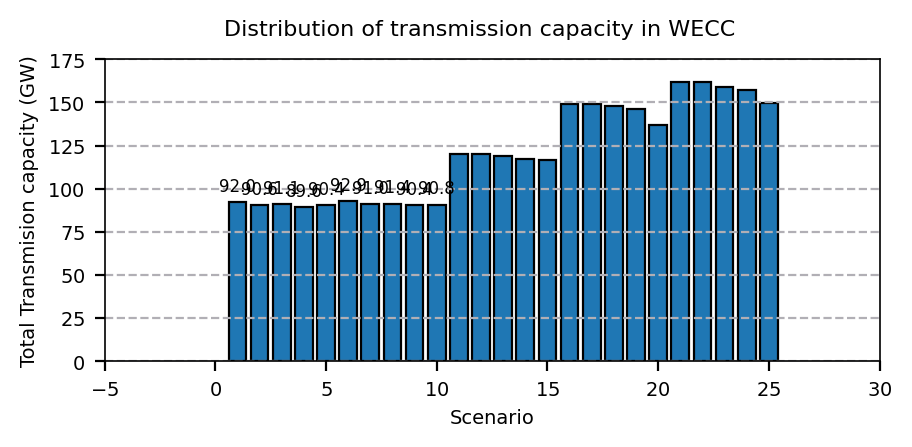

In [20]:
fig, ax = plt.subplots(figsize=(5, 2), dpi=200)

fig.patch.set_facecolor('white')

ax.bar(build_Tx_total_GW.index,height=build_Tx_total_GW['Tx_total_GW'])
#ax.set_xlim(left=0)

ax.set_xlabel("Scenario",fontsize=7)
ax.set_ylabel("Total Transmision capacity (GW)",fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
ax.grid(axis='y', linestyle='dashed')

fig.suptitle("Distribution of transmission capacity in WECC")
ax.patch.set_facecolor('white')

xlocs, xlabs = plt.xticks()
xlocs=[i+1 for i in range(0,10)]
xlabs=[i/2 for i in range(0,10)]
for i, v in enumerate(build_Tx_total_GW['Tx_total_GW']):
    plt.text(xlocs[i]-1, v+4, str(round(v,1)),horizontalalignment="center", verticalalignment="bottom",fontsize=6)
plt.show()

plt.savefig("Distribution of transmission capacity in WECC.png", transparent=False)

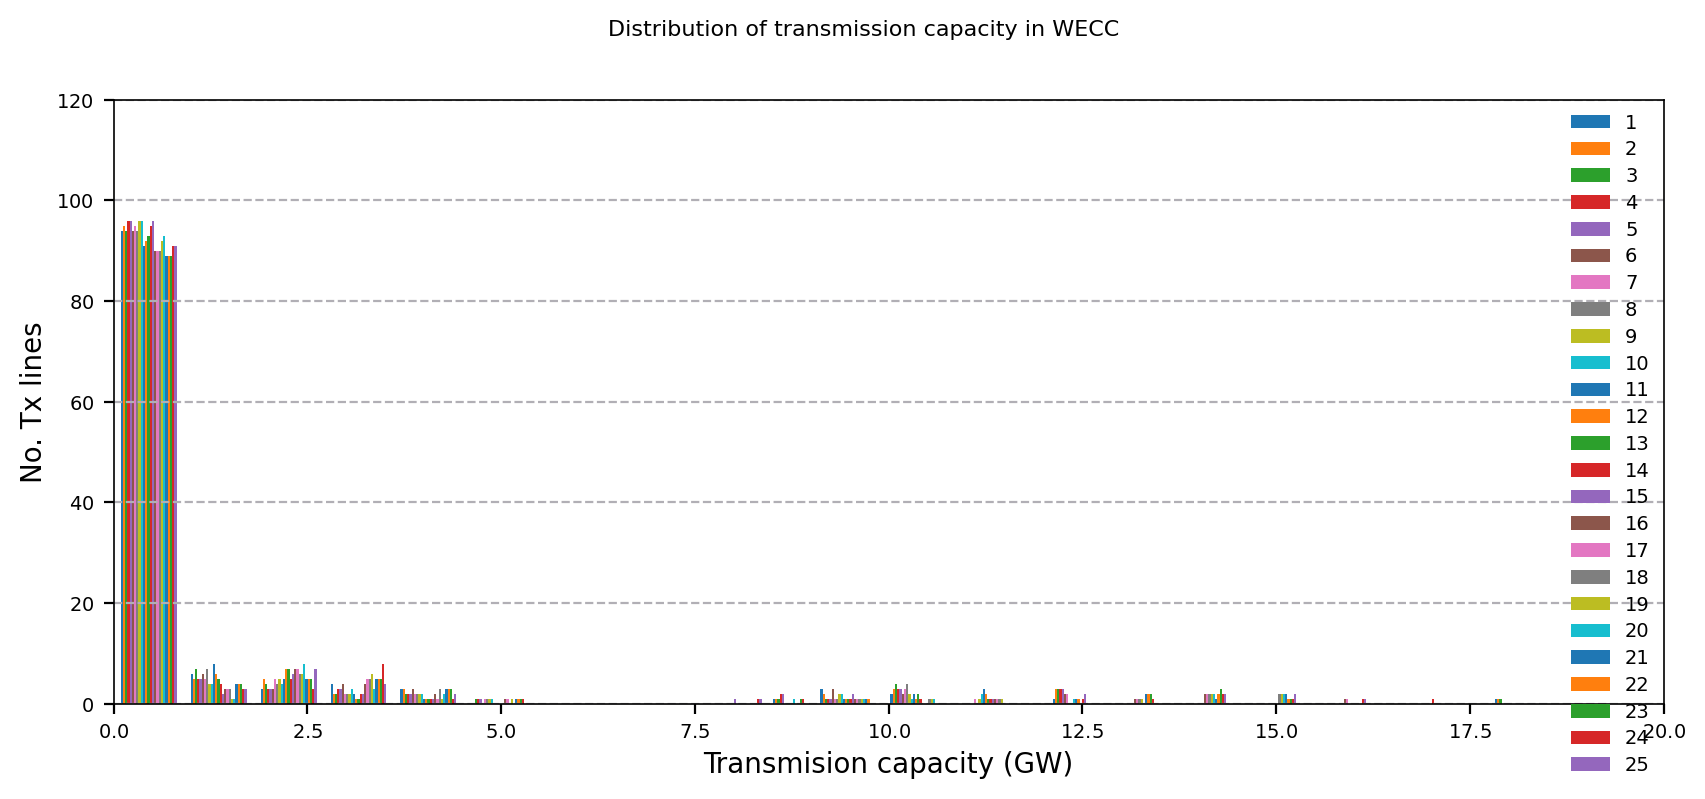

In [18]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=200)

fig.patch.set_facecolor('white')

ax.hist(build_Tx_GW.values, lw=0, bins=20, label=build_Tx_GW.columns.values)
ax.set_xlim(left=0)

ax.set_xlabel("Transmision capacity (GW)")
ax.set_ylabel("No. Tx lines")
plt.legend(fontsize=7)

ax.grid(axis='y', linestyle='dashed')

fig.suptitle("Distribution of transmission capacity in WECC")

ax.patch.set_facecolor('white')

plt.savefig("Distribution of transmission capacity in WECC.png", transparent=False)

### New capacity by transmission line

scenario,1,2,3,4,5,6,7,8,9,10
Tx_lz,,,,,,,,,,
1-2: AZ_APS_E to AZ_APS_N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-4: AZ_APS_E to AZ_NM_N,2.6,2.6,2.1,1.1,1.0,5.1,3.6,2.5,0.9,0.5
1-6: AZ_APS_E to AZ_PHX,2.2,2.3,1.8,0.7,0.4,4.6,3.3,2.1,0.6,0.0
1-7: AZ_APS_E to AZ_SE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-34: AZ_APS_E to NM_S_TX_EPE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
47-48: WY_NE to WY_NW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47-49: WY_NE to WY_SE,0.0,0.0,0.1,0.1,0.1,0.0,0.0,0.1,0.1,0.1
48-49: WY_NW to WY_SE,14.1,14.6,15.5,15.5,16.1,15.1,15.4,15.6,15.6,16.1


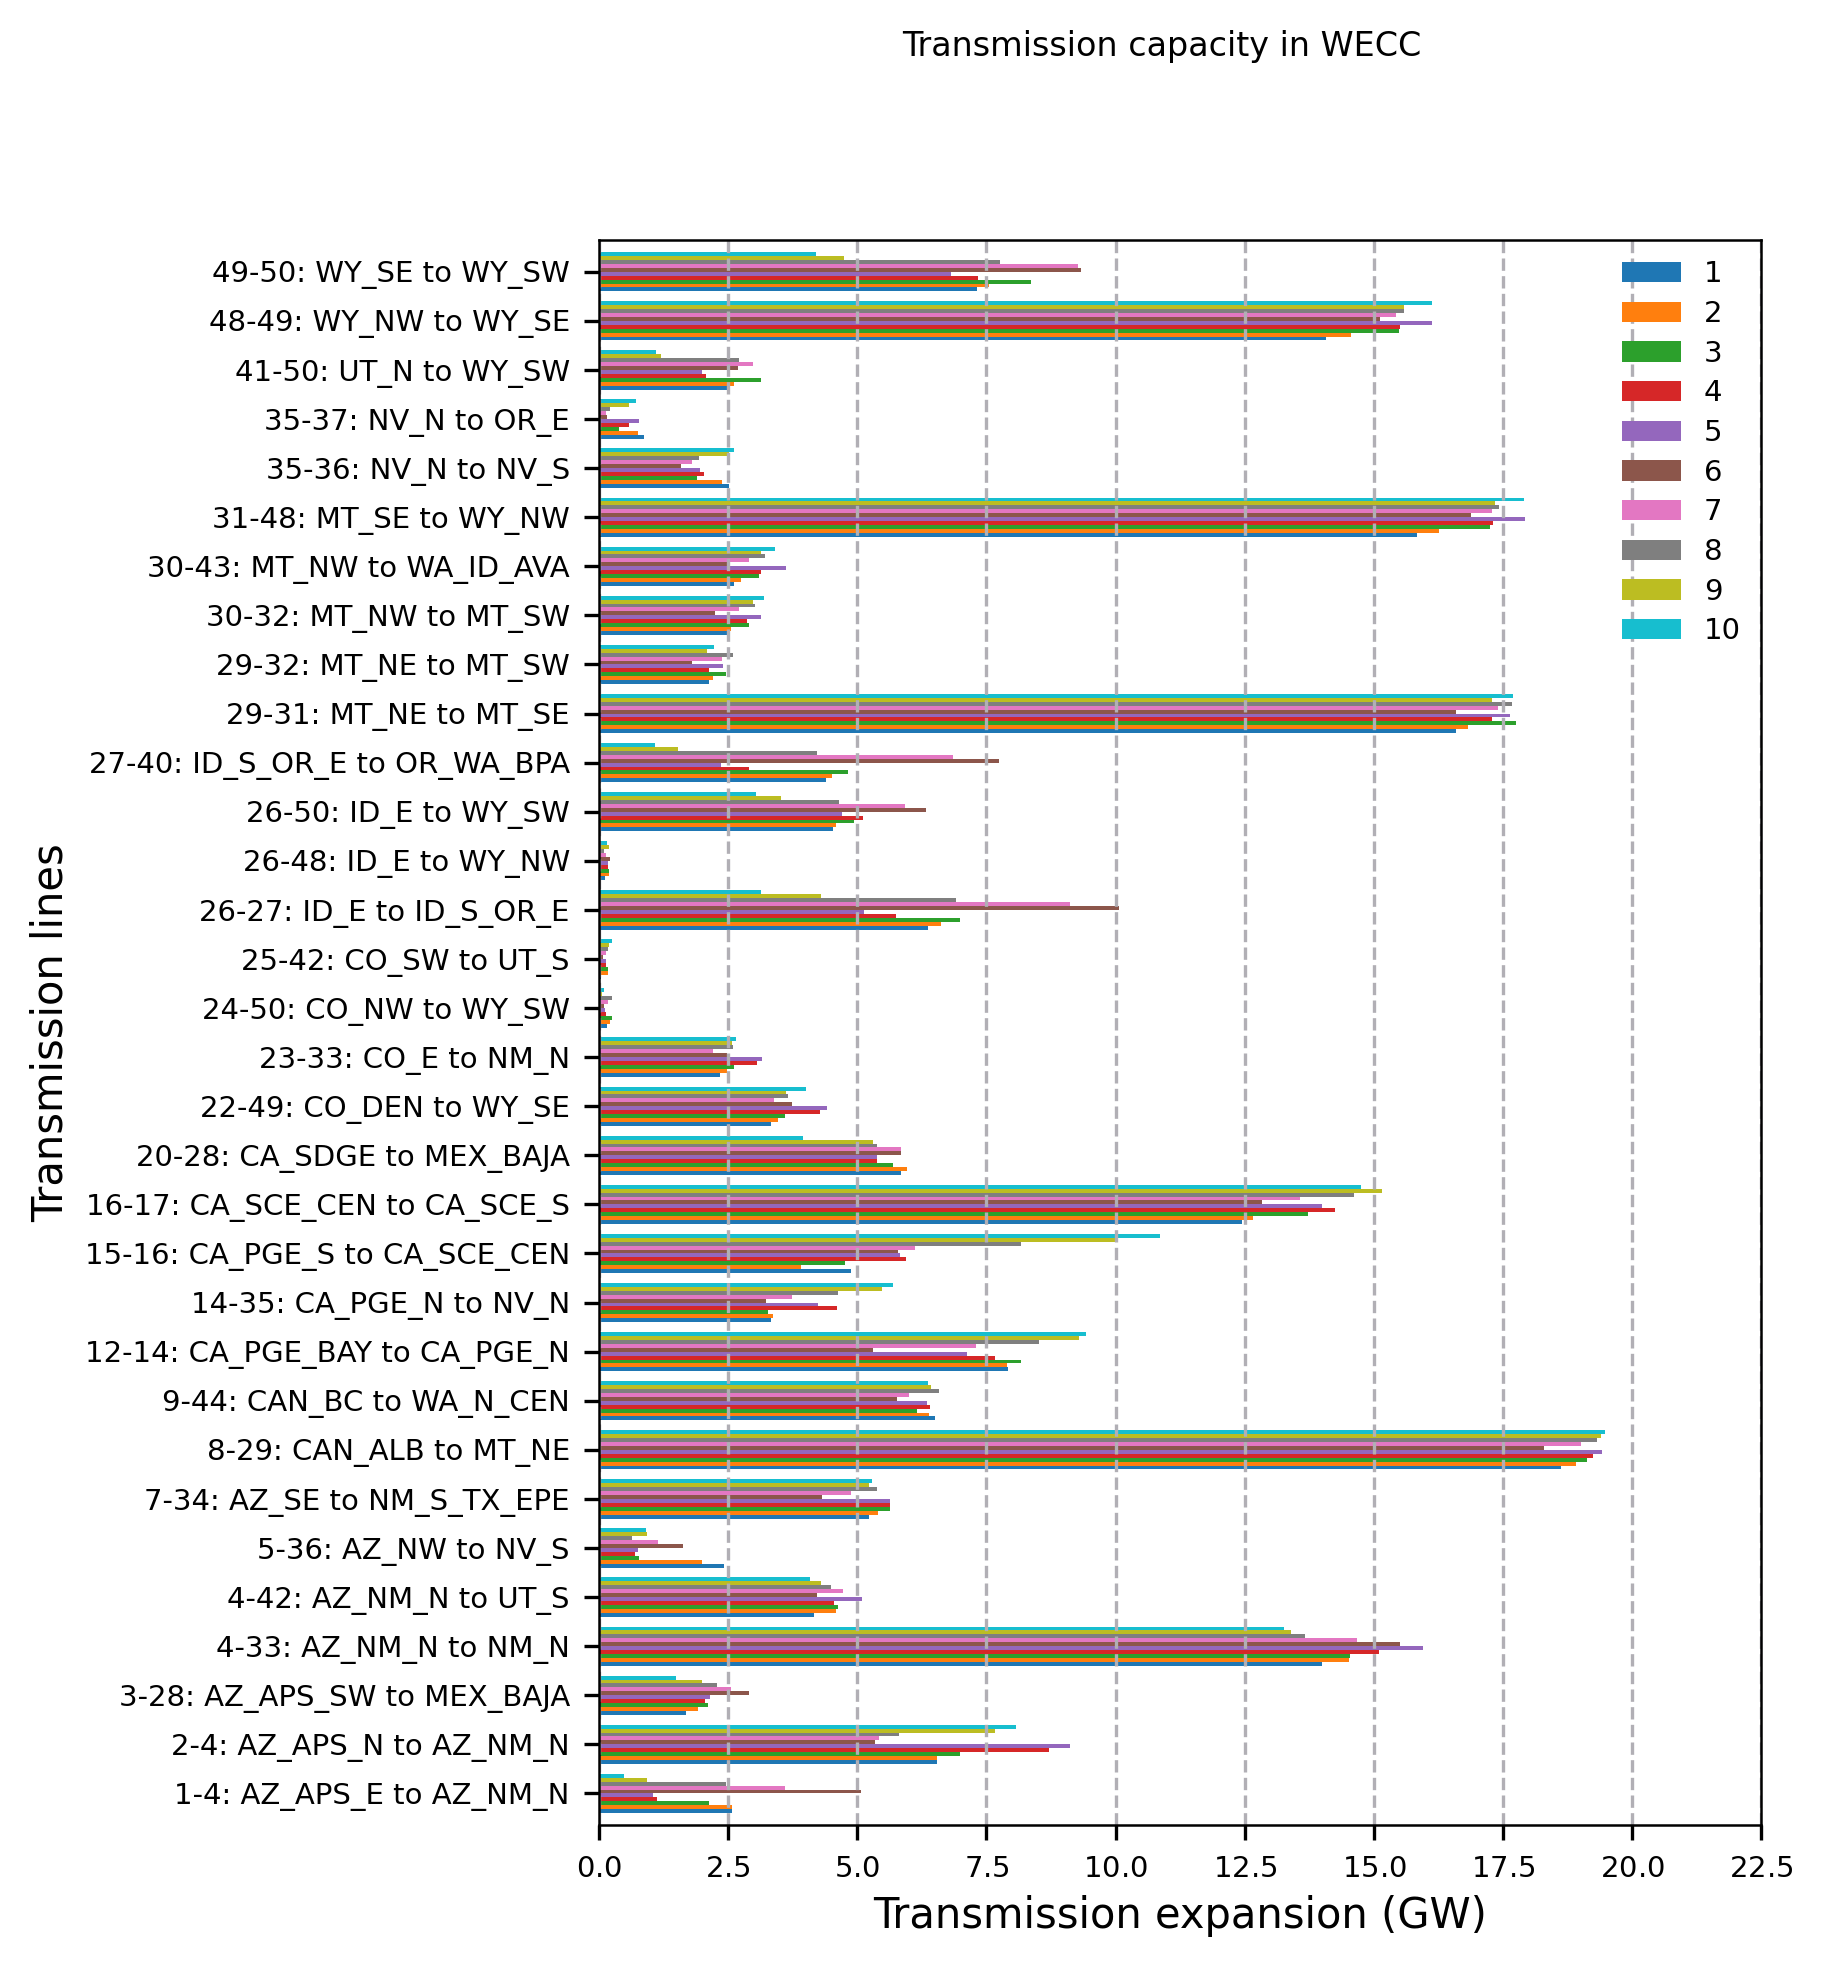

In [71]:
# Start figure environment
fig = plt.figure(figsize=(5,  7), dpi=300)

fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

# Exclude transmission lines with 0 additions
data = (build_Tx_GW[build_Tx_GW != 0]).dropna()

# Main figure
data.plot.barh(ax=ax, lw=0, width=0.8)
plt.xlabel("Transmission expansion (GW)")
plt.ylabel("Transmission lines")

ax.grid(axis='x', linestyle='dashed')

fig.suptitle("Transmission capacity in WECC")

ax.patch.set_facecolor('white')

plt.savefig("Transmission capacity in WECC.png", transparent=False)

plt.legend(fontsize=7)

build_Tx_GW

### California in-state expansion

In [72]:
#build_Tx_inCa = build_Tx_meta[build_Tx_meta.trans_lz1.str.contains("CA_")]
build_Tx_inCa = build_Tx_meta.loc[build_Tx_meta.trans_lz1.str.contains("CA_") & build_Tx_meta.trans_lz2.str.contains("CA_")]

build_Tx_inCa_MW = build_Tx_inCa.pivot_table(
    index="Tx_lz", columns="scenario", values="BuildTx", aggfunc=np.sum
)

build_Tx_inCa_MW["index1"]= build_Tx_inCa_MW.index.str.extract("(\d+)", expand=False).astype(int)
build_Tx_inCa_MW["index2"]= build_Tx_inCa_MW.index.str.extract(".-(\d+)", expand=False).astype(int)

build_Tx_inCa_MW = build_Tx_inCa_MW.sort_values(["index1", "index2"]).loc[
    :, build_Tx.scenario.unique()]

# Convert units
build_Tx_inCa_GW = build_Tx_inCa_MW / 1e3  # MW to GW   

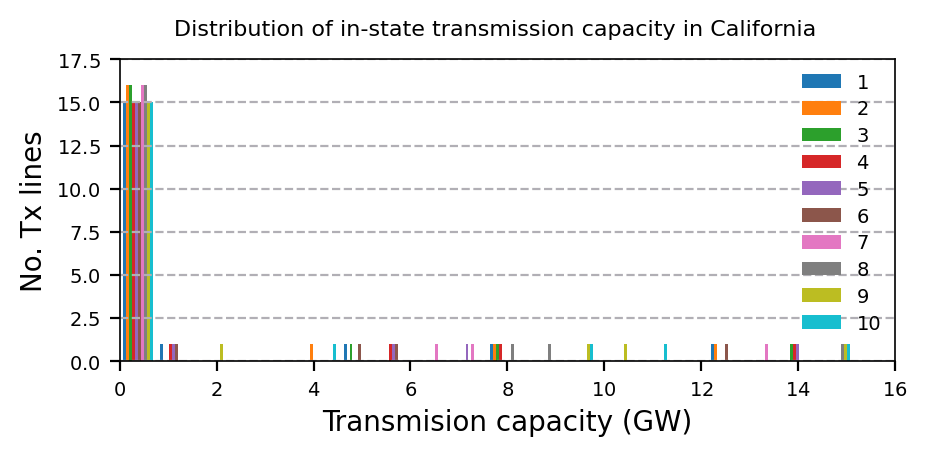

In [73]:
#Plot
fig = plt.figure(figsize=(5,  2), dpi=200)

fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.hist(build_Tx_inCa_GW.values, lw=0, bins=20, label=build_Tx_inCa_GW.columns.values)
ax.set_xlim(left=0)

ax.set_xlabel("Transmision capacity (GW)")
ax.set_ylabel("No. Tx lines")
ax.grid(axis='y', linestyle='dashed')
plt.legend(fontsize=7)

fig.suptitle("Distribution of in-state transmission capacity in California")

ax.patch.set_facecolor('white')

plt.savefig("Distribution of In-state transmission capacity in California.png", transparent=False)

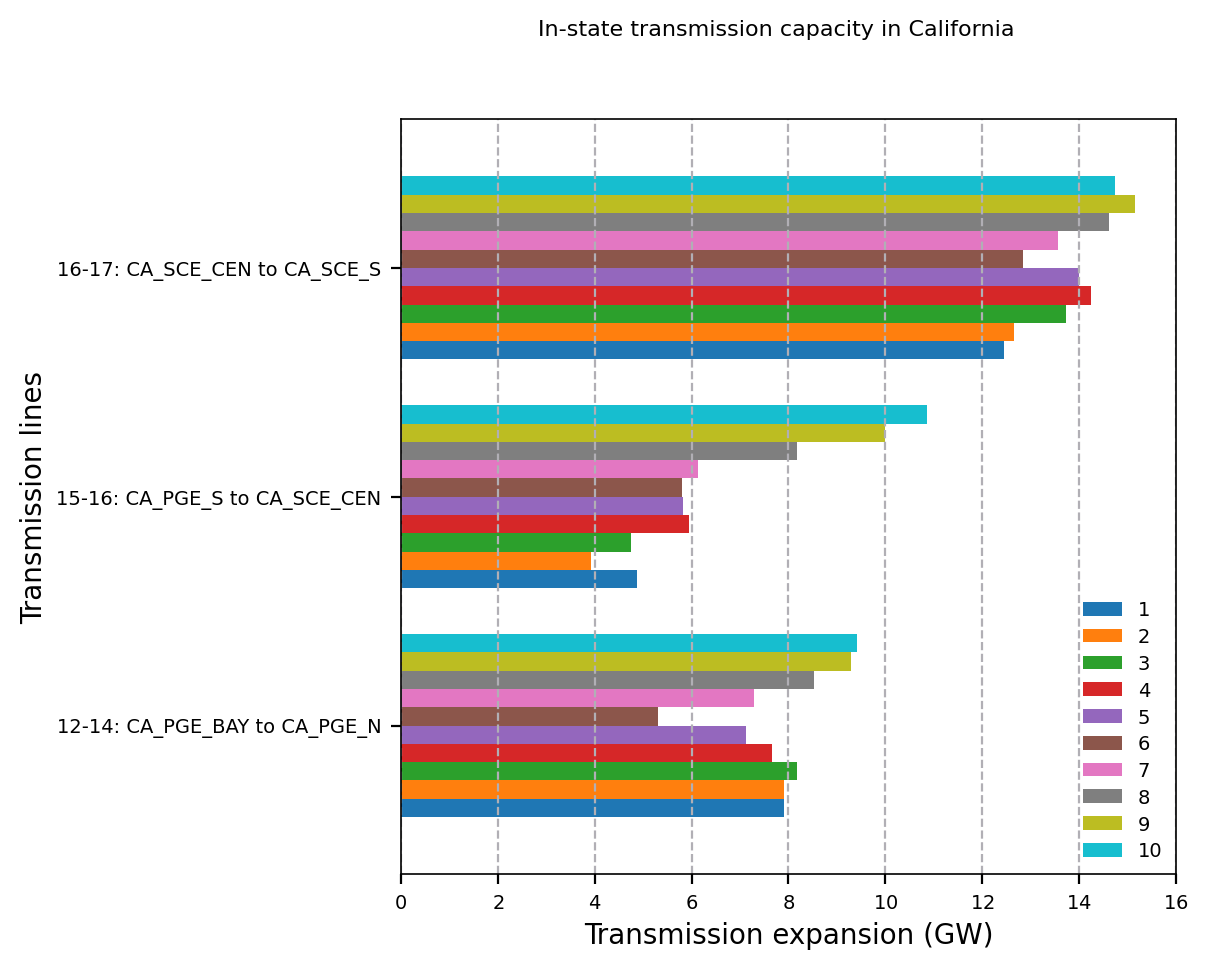

In [74]:
# Start figure environment
fig = plt.figure(figsize=(5,  5), dpi=200)

fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

# Exclude transmission lines with 0 additions
data_inCA = (build_Tx_inCa_GW[build_Tx_inCa_GW != 0]).dropna()

# Main figure
data_inCA.plot.barh(ax=ax, lw=0, width=0.8)
plt.xlabel("Transmission expansion (GW)")
plt.ylabel("Transmission lines")

ax.grid(axis='x', linestyle='dashed')
fig.suptitle("In-state transmission capacity in California")

plt.legend(fontsize=7)

ax.patch.set_facecolor('white')

plt.savefig("In-state transmission capacity in California.png", transparent=False)


### Tie transmission expansion

In [75]:
build_Tx_tieCa = build_Tx_meta.loc[build_Tx_meta.trans_lz1.str.contains("CA_") ^ build_Tx_meta.trans_lz2.str.contains("CA_")]

build_Tx_tieCa_MW = build_Tx_tieCa.pivot_table(
    index="Tx_lz", columns="scenario", values="BuildTx", aggfunc=np.sum
)

build_Tx_tieCa_MW["index1"]= build_Tx_tieCa_MW.index.str.extract("(\d+)", expand=False).astype(int)
build_Tx_tieCa_MW["index2"]= build_Tx_tieCa_MW.index.str.extract(".-(\d+)", expand=False).astype(int)

build_Tx_tieCa_MW = build_Tx_tieCa_MW.sort_values(["index1", "index2"]).loc[
    :, build_Tx.scenario.unique()]

# Convert units
build_Tx_tieCa_GW = build_Tx_tieCa_MW / 1e3  # MW to GW  

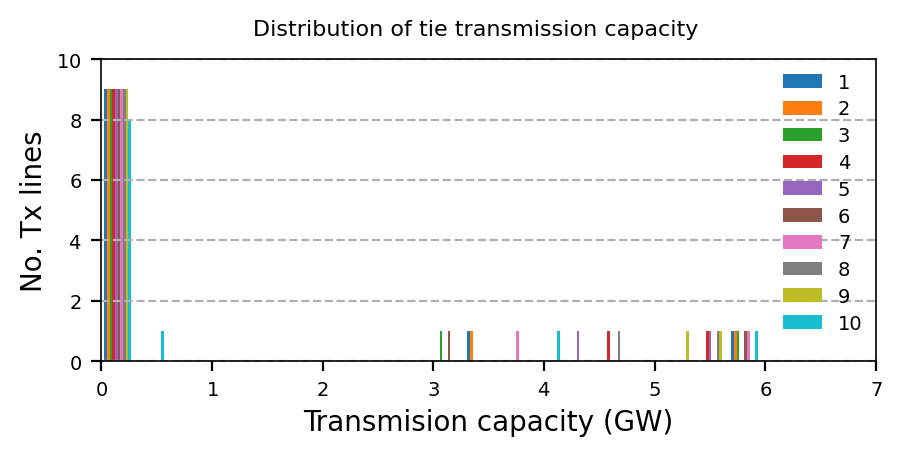

In [76]:
#Plot
fig = plt.figure(figsize=(5,  2), dpi=200)

fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.hist(build_Tx_tieCa_GW.values, lw=0, bins=20, label=build_Tx_tieCa_GW.columns.values)
ax.set_xlim(left=0)

ax.set_xlabel("Transmision capacity (GW)")
ax.set_ylabel("No. Tx lines")

ax.grid(axis='y', linestyle='dashed')

plt.legend(fontsize=7)

fig.suptitle("Distribution of tie transmission capacity")

ax.patch.set_facecolor('white')

plt.savefig("Distribution of tie transmission capacity.png", transparent=False)


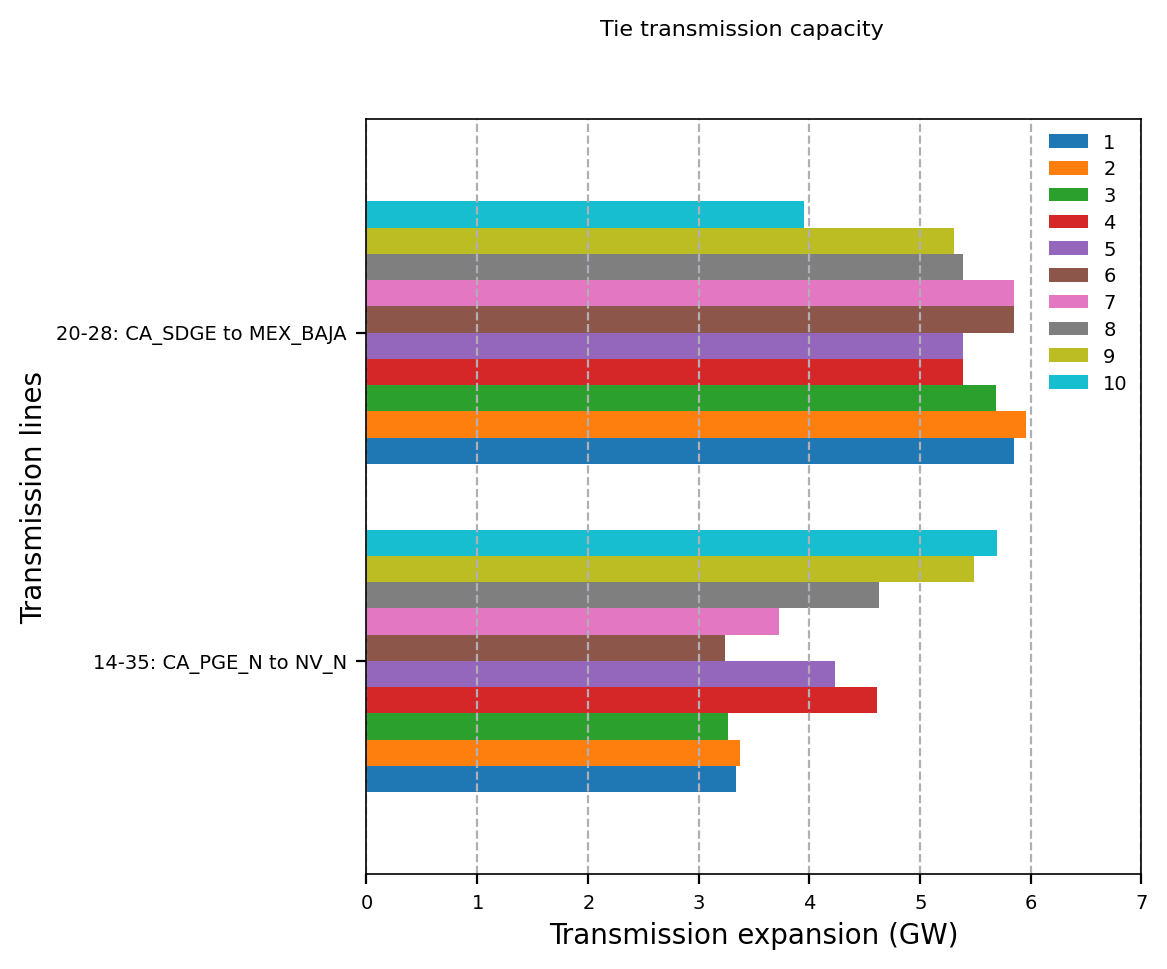

In [77]:
# Start figure environment
fig = plt.figure(figsize=(5,  5), dpi=200)
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

# Exclude transmission lines with 0 additions
data_tieCA = (build_Tx_tieCa_GW[build_Tx_tieCa_GW != 0]).dropna()

# Main figure
data_tieCA.plot.barh(ax=ax, lw=0, width=0.8)
plt.xlabel("Transmission expansion (GW)")
plt.ylabel("Transmission lines")

ax.grid(axis='x', linestyle='dashed')
fig.suptitle("Tie transmission lines")

plt.legend(fontsize=7)

fig.suptitle("Tie transmission capacity")

ax.patch.set_facecolor('white')

plt.savefig("Tie transmission capacity.png", transparent=False)